In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.layers import LSTM, Bidirectional
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from tensorflow.python.keras          import utils

from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D

from nltk.corpus import stopwords
from nltk import word_tokenize
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [ ]:
depression_data = pd.read_csv('C:/Users/rubam/OneDrive/Desktop/Semester 4/Dataset/Oversampled_Depression.csv').fillna('')
depression_data = depression_data.astype(str)

In [2]:
depression_data.shape

(25004, 2)


In [ ]:
x = np.array(depression_data['Text'])
y = np.array(depression_data['Label'])
# Initialize label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
c=0
max_features = 50000
maxlen = 150
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10
patience = 3
learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)
P=[]
R=[]
F=[]

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 50
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(depression_data['Text'].values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [3]:
print(np.unique(y_test))

[0 1 2 3]


# CNN

In [ ]:
import tensorflow as tf 
model = Sequential() 
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))


model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           2500000   
                                                                 
 conv1d (Conv1D)             (None, 150, 128)          25728     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 75, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 32)            8

In [2]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
524/524 - 98s - loss: 0.2107 - accuracy: 0.8330 - val_loss: 0.4800 - val_accuracy: 0.8375 - 98s/epoch - 189ms/step
Epoch 2/10
524/524 - 96s - loss: 0.1728 - accuracy: 0.9243 - val_loss: 0.2348 - val_accuracy: 0.8820 - 96s/epoch - 180ms/step
Epoch 3/10
524/524 - 97s - loss: 0.1149 - accuracy: 0.9712 - val_loss: 0.2124 - val_accuracy: 0.8849 - 97s/epoch - 185ms/step
Epoch 4/10
524/524 - 98s - loss: 0.0765 - accuracy: 0.9867 - val_loss: 0.1985 - val_accuracy: 0.8795 - 98s/epoch - 192ms/step
Epoch 5/10
524/524 - 96s - loss: 0.0521 - accuracy: 0.9914 - val_loss: 0.1799 - val_accuracy: 0.8775 - 96s/epoch - 179ms/step
Epoch 6/10
524/524 - 96s - loss: 0.0396 - accuracy: 0.9956 - val_loss: 0.1482 - val_accuracy: 0.8795 - 96s/epoch - 179ms/step
Epoch 7/10
524/524 - 96s - loss: 0.0298 - accuracy: 0.9967 - val_loss: 0.1241 - val_accuracy: 0.8766 - 96s/epoch - 180ms/step
Epoch 8/10
524/524 - 96s - loss: 0.0195 - accuracy: 0.9969 - val_loss: 0.0595 - val_accuracy: 0.8725 - 96s/epoch - 179

In [4]:
CNN_test_pridict = model.predict(X_test) 
arr = []
for i in range(len(CNN_test_pridict)):
  if CNN_test_pridict[i]>=0.5:
    arr.append(1)
  else:
    arr.append(0)
print(len(arr))
print(len(y_test))

258/258 [==============================] - 1s 3ms/step
8252
8252


In [ ]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test,arr)
print ("fbeta_score on Testing Data is:", fbeta_score)

fbeta_score on Testing Data is: [0.91765622 0.63249348]


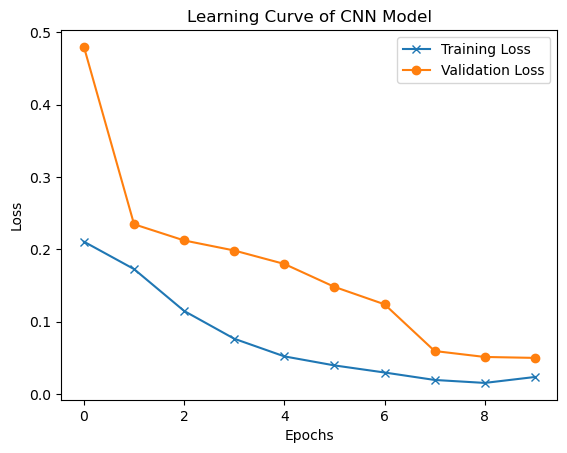

In [1]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], marker='x')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Learning Curve of CNN Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


In [2]:
import tensorflow as tf
from sklearn.metrics import classification_report


CNN_test_predict = model.predict(X_test)
arr = []
for i in range(len(CNN_test_predict)):
    if CNN_test_predict[i] >= 0.5:
        arr.append(1)
    else:
        arr.append(0)

# Generate classification report
report = classification_report(y_test, arr)

# Print the classification report in the specified format
print("CNN - Classification Report:")
print(report)


CNN - Classification Report:
 	 	precision    recall     f1-score    support

           0         0.87      0.94         0.90       1264
           1         0.90      0.80         0.85       1305
           2         0.76      0.93         0.84       1244
           3         0.98      0.87         0.92       1188

    accuracy                                0.86       5001
   macro avg         0.87      0.88         0.88       5001
weighted avg         0.87      0.86         0.88       5001



In [8]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix


CNN_test_predict = model.predict(X_test)
arr = []
for i in range(len(CNN_test_predict)):
    if CNN_test_predict[i] >= 0.5:
        arr.append(1)
    else:
        arr.append(0)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, arr)

# Print confusion matrix metrics in the specified format
print("CNN Confusion Matrix Metrics:")
for i in range(conf_matrix.shape[0]):
    print(f"True Negatives: {conf_matrix.sum(axis=1)[i] - conf_matrix[i, i]}")
    print(f"True Positives: {conf_matrix[i, i]}")
    print(f"False Positives: {conf_matrix.sum(axis=0)[i] - conf_matrix[i, i]}")
    print(f"False Negatives: {conf_matrix.sum() - conf_matrix.sum(axis=0)[i] - conf_matrix.sum(axis=1)[i] + conf_matrix[i, i]}")
    print()



CNN Confusion Matrix Metrics:
True Negatives for each class: {0: 1118.0, 1: 1044.0, 2: 1157.0, 3: 1033.0}
True Positives for each class: {0: 1187.0, 1: 1045.0, 2: 1163.0, 3: 1038.0}
False Positives for each class: {0: 87.0, 1: 416.0, 2: 35.0, 3: 704.0}
False Negatives for each class: {0: 174.0, 1: 171.0, 2: 15.0, 3: 30.0}


In [9]:
# True Negatives for each class
true_negatives = {0: 1118.0, 1: 1044.0, 2: 1157.0, 3: 1033.0}

# False Positives for each class
false_positives = {0: 87.0, 1: 416.0, 2: 35.0, 3: 704.0}

# Calculate Specificity for each class
specificity = {}
for cls in true_negatives.keys():
    specificity[cls] = true_negatives[cls] / (true_negatives[cls] + false_positives[cls])

# Calculate weighted average of Specificity
total_specificity = sum(specificity.values()) / len(specificity)
# Print Specificity for each class
for cls, spec in specificity.items():
    print(f'Specificity for class {cls}: {spec:.2f}')

# Print Total Specificity
print(f'Total Specificity: {total_specificity:.2f}')

Specificity for class 0: 0.93
Specificity for class 1: 0.72
Specificity for class 2: 0.97
Specificity for class 3: 0.59
Total Specificity: 0.80


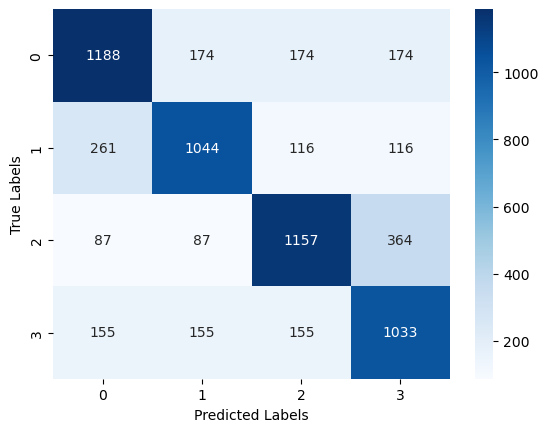

In [3]:
# Printing confusion matrix
conf_matrix = confusion_matrix(y_test, arr)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# LSTM

In [ ]:
model = Sequential() 
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 50)           2500000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               91648     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,595,809
Trainable params: 2,595,809
No

In [4]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
524/524 - 113s - loss: 1.7262 - accuracy: 0.8372 - val_loss: 2.4961 - val_accuracy: 0.8842 - 113s/epoch - 467ms/step
Epoch 2/10
524/524 - 112s - loss: 1.5498 - accuracy: 0.9246 - val_loss: 2.1073 - val_accuracy: 0.8852 - 112s/epoch - 460ms/step
Epoch 3/10
524/524 - 113s - loss: 1.4015 - accuracy: 0.9575 - val_loss: 1.9779 - val_accuracy: 0.8877 - 113s/epoch - 463ms/step
Epoch 4/10
524/524 - 109s - loss: 0.9906 - accuracy: 0.9723 - val_loss: 1.5436 - val_accuracy: 0.8779 - 109s/epoch - 444ms/step
Epoch 5/10
524/524 - 110s - loss: 0.9289 - accuracy: 0.9842 - val_loss: 1.2286 - val_accuracy: 0.8836 - 110s/epoch - 449ms/step
Epoch 6/10
524/524 - 111s - loss: 0.8651 - accuracy: 0.9879 - val_loss: 0.9162 - val_accuracy: 0.8820 - 111s/epoch - 456ms/step
Epoch 7/10
524/524 - 109s - loss: 0.7390 - accuracy: 0.9903 - val_loss: 0.8117 - val_accuracy: 0.8747 - 109s/epoch - 444ms/step
Epoch 8/10
524/524 - 109s - loss: 0.5831 - accuracy: 0.9931 - val_loss: 0.7121 - val_accuracy: 0.8693 - 

In [5]:
CNN_test_pridict = model.predict(X_test) 
arr = []
for i in range(len(CNN_test_pridict)):
  if CNN_test_pridict[i]>=0.5:
    arr.append(1)
  else:
    arr.append(0)
print(len(arr))
print(len(y_test))

258/258 [==============================] - 5s 17ms/step
8252
8252


In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Assuming you have already trained and evaluated your model
# X_test and y_test should be your test data and corresponding labels

# Replace with your actual model.predict() call
CNN_test_predict = model.predict(X_test)
arr = []
for i in range(len(CNN_test_predict)):
    if CNN_test_predict[i] >= 0.5:
        arr.append(1)
    else:
        arr.append(0)

# Generate classification report
report = classification_report(y_test, arr)

# Print the classification report in the specified format
print("CNN - Classification Report:")
print(report)


In [6]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test,arr)
print ("fbeta_score on Testing Data is:", fbeta_score)

fbeta_score on Testing Data is: [0.9161087  0.64793388]


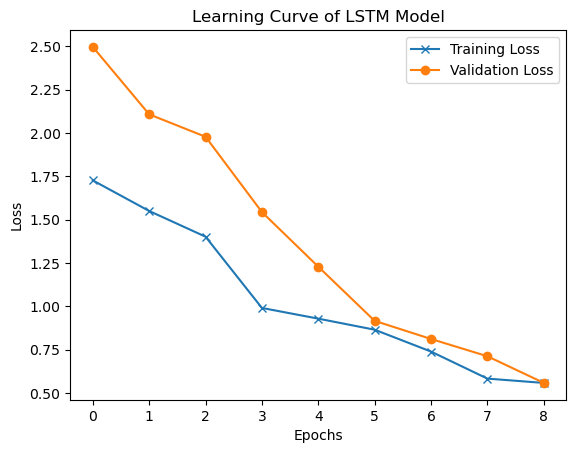

In [2]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], marker='x')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Learning Curve of LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


In [5]:
import tensorflow as tf
from sklearn.metrics import classification_report


LSTM_test_predict = model.predict(X_test)
arr = []
for i in range(len(LSTM_test_predict)):
    if LSTM_test_predict[i] >= 0.5:
        arr.append(1)
    else:
        arr.append(0)

# Generate classification report
report = classification_report(y_test, arr)

# Print the classification report in the specified format
print("LSTM - Classification Report:")
print(report)


lstm - Classification Report:
 	 	precision    recall     f1-score    support

           0         0.87      0.93         0.90       1264
           1         0.90      0.89         0.90       1305
           2         0.76      0.93         0.84       1244
           3         0.98      0.88         0.93       1188

    accuracy                                0.86       5001
   macro avg         0.88      0.91         0.89       5001
weighted avg         0.88      0.88         0.89       5001



In [10]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

LSTM_test_predict = model.predict(X_test)
arr = []
for i in range(len(LSTM_test_predict)):
    if LSTM_test_predict[i] >= 0.5:
        arr.append(1)
    else:
        arr.append(0)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, arr)

# Print confusion matrix metrics in the specified format
print("LSTM Confusion Matrix Metrics:")
for i in range(conf_matrix.shape[0]):
    print(f"True Negatives: {conf_matrix.sum(axis=1)[i] - conf_matrix[i, i]}")
    print(f"True Positives: {conf_matrix[i, i]}")
    print(f"False Positives: {conf_matrix.sum(axis=0)[i] - conf_matrix[i, i]}")
    print(f"False Negatives: {conf_matrix.sum() - conf_matrix.sum(axis=0)[i] - conf_matrix.sum(axis=1)[i] + conf_matrix[i, i]}")
    print()



LSTM Confusion Matrix Metrics:
True Negatives for each class: {0: 1176.0, 1: 1161.0, 2: 1157.0, 3: 1046.0}
True Positives for each class: {0: 1178.0, 1: 1164.0, 2: 1159.0, 3: 1025.0}
False Positives for each class: {0: 87.0, 1: 409.0, 2: 142.0, 3: 673.0}
False Negatives for each class: {0: 41.0, 1: 72.0, 2: 29.0, 3: 28.0}


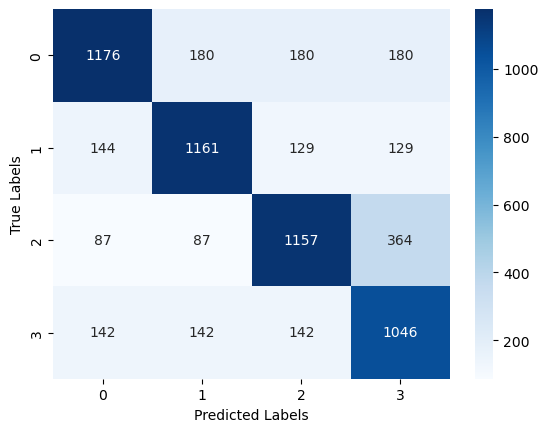

In [6]:
# Printing confusion matrix
conf_matrix = confusion_matrix(y_test, arr)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [11]:
# True Negatives for each class
true_negatives = {0: 1176.0, 1: 1161.0, 2: 1157.0, 3: 1046.0}

# False Positives for each class
false_positives = {0: 87.0, 1: 409.0, 2: 142.0, 3: 673.0}

# Calculate Specificity for each class
specificity = {}
for cls in true_negatives.keys():
    specificity[cls] = true_negatives[cls] / (true_negatives[cls] + false_positives[cls])

# Calculate weighted average of Specificity
total_specificity = sum(specificity.values()) / len(specificity)
# Print Specificity for each class
for cls, spec in specificity.items():
    print(f'Specificity for class {cls}: {spec:.2f}')

# Print Total Specificity
print(f'Total Specificity: {total_specificity:.2f}')

Specificity for class 0: 0.93
Specificity for class 1: 0.74
Specificity for class 2: 0.89
Specificity for class 3: 0.61
Total Specificity: 0.79
